<a href="https://colab.research.google.com/github/Gooogr/Book_nlp_with_transformers/blob/main/ch8_optimization_for_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will explore four complementary opimization techniques for transformer models: 
* Knowledge distillation
* Quantization
* Pruning
* Graph optimization 

with the Open Neural Network Exchange (ONNX) format and ONNX Runtime (ORT).

Let’s suppose that we’re trying to build a text-based assistant for our company’s call
center so that customers can request their account balance or make bookings without
needing to speak with a human agent. In order to understand the goals of a customer,
our assistant will need to be able to classify a wide variety of natural language text
into a set of predefined actions or intents.

In [1]:
!pip install -qq transformers[sentencepiece] datasets

     |████████████████████████████████| 4.2 MB 7.8 MB/s 
     |████████████████████████████████| 346 kB 66.0 MB/s 
     |████████████████████████████████| 1.1 MB 52.3 MB/s 
     |████████████████████████████████| 212 kB 63.6 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 140 kB 70.4 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
     |████████████████████████████████| 127 kB 75.4 MB/s 
     |████████████████████████████████| 94 kB 784 kB/s 
     |████████████████████████████████| 144 kB 55.5 MB/s 
     |████████████████████████████████| 271 kB 57.9 MB/s 
     |████████████████████████████████| 112 kB 55.0 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 
     |████████████████████████████████| 1.2 MB 47.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source o

In [2]:
! nvidia-smi

Sun Jun  5 21:02:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
from transformers import pipeline, TrainingArguments, Trainer,  AutoTokenizer
from transformers import AutoConfig, AutoModelForSequenceClassification
from datasets import load_dataset, load_metric
# from huggingface_hub import notebook_login

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from time import perf_counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# notebook_login()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [6]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

# Load Dataset (CLINC 150)

In [7]:
# Load ClINC150 datasets
clinc = load_dataset('clinc_oos', 'plus')

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# General info
print(clinc)

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})


In [9]:
# Dataset sample
intents = clinc["test"].features["intent"]
get_intent = lambda x: intents.int2str(x)

sample = clinc['test'][42]
sample['intent_text'] = get_intent(sample['intent'])
print(sample)

{'text': 'transfer $100 from my checking to saving account', 'intent': 133, 'intent_text': 'transfer'}


# Creating a performance benchamark

In [10]:
accuracy_score = load_metric("accuracy")

In [11]:
# list(pipe.model.state_dict().items())[42]

In [12]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"]
            label = example["intent"]
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy


    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self, query="What is the pin number for my account?"):
        '''
        Function measure the average latency per query.
        '''
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}


    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [13]:
%%time
# test run ~ 7 min
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 70.04 +\- 3.05
Accuracy on test set - 0.867
CPU times: user 7min 14s, sys: 1.4 s, total: 7min 15s
Wall time: 7min 32s


# Knowledge Distillation

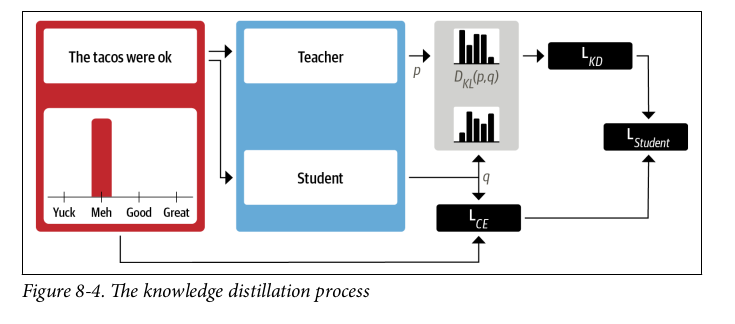

### Creating a Knowledge Distillation Trainer

To implement knowledge distillation we need to add a few things to the Trainer base
class:
* The new hyperparameters α and T, which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed
* The fine-tuned teacher model, which in our case is BERT-base
* A new loss function that combines the cross-entropy loss with the knowledge distillation loss

Adding new hyperparameters:

In [14]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

For the trainer itself, we need a new loss function. The way to implement this is by
subclassing Trainer and overriding the compute_loss() method to include the
knowledge distillation loss term L KD :

In [15]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

In general we should pick a smaller model for the student to reduce the latency and memory footprint. A good rule of thumb from the literature is that knowledge distillation works best when the teacher and student are of the same model type.

One possible reason for this is that different model types, say BERT and RoBERTa, can have different output embedding spaces, which hinders the ability of the student to mimic the teacher. In our case
study the teacher is BERT, so DistilBERT is a natural candidate to initialize the student with since it has 40% fewer parameters and has been shown to achieve strong results on downstream tasks.

In [16]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [17]:
def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

In [18]:
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Define metrics to track during training

In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

Define training arguments

In [20]:
batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(
        output_dir=finetuned_ckpt, 
        evaluation_strategy = "epoch",
        num_train_epochs=5, 
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size, 
        alpha=1,           # ALPHA=1 is warmup option, to test DistilBERT without teacher influence
        weight_decay=0.01,
        push_to_hub=True)  # Change PUSH_TO_HUB if necessary

One other thing we need to do is provide the student model with the mappings
between each intent and label ID.

In [21]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

With these mappings, we can now create a custom model configuration with the
AutoConfig class

In [24]:
num_labels = intents.num_classes
student_config = (AutoConfig.
                  from_pretrained(student_ckpt, num_labels=num_labels,
                                  id2label=id2label, label2id=label2id))

In [25]:
def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

### Distill  training

In [29]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                .from_pretrained(teacher_ckpt, num_labels=num_labels)
                .to(device))

distilbert_trainer = DistillationTrainer(model_init=student_init,
                                         teacher_model=teacher_model, 
                                         args=student_training_args,
                                         train_dataset=clinc_enc['train'], 
                                         eval_dataset=clinc_enc['validation'],
                                         compute_metrics=compute_metrics, 
                                         tokenizer=student_tokenizer)
distilbert_trainer.train()

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpan6zaw0m


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias'

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.288972,0.742903
2,3.786800,1.875608,0.837419
3,3.786800,1.157074,0.896129
4,1.692900,0.857376,0.913226
5,0.905700,0.772111,0.918387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=1590, training_loss=2.0514166298152516, metrics={'train_runtime': 323.433, 'train_samples_per_second': 235.752, 'train_steps_per_second': 4.916, 'total_flos': 413896353421488.0, 'train_loss': 2.0514166298152516, 'epoch': 5.0})